In [48]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Activation function methods are ready, which will be used in the neural network, if act_type = 0 we use log sigmoid activation function, if act_type = 1 we use tanh activation function, and last if act_type = 2 we use relu activation function.

Refer to 'Table of activation functions' from https://en.wikipedia.org/wiki/Activation_function for activation function.

In [50]:
def sigmoid(X):
    return (1/(1+np.exp(-X)))

# Will be used as activation function for hidden as well as output layer
def tanh(X):
    return np.tanh(X)

def relu(X):
    return X.clip(0)

def derivative_sigmoid(X):
    return X*(1-X)

def derivative_tanh(X):
    return 1-np.power(X, 2)

def derivative_relu(X):
    return (X>0).astype('float32')

# Will be used in last Layer if Cross Entropy losss function is used
def softmax(X):
    x = np.exp(X)
    return x/np.sum(x, axis=1, keepdims=True)


Loss function if loss_type = 0 we use Cross Entropy as our Loss function and if loss_type = 1 we use Mean Squared Error as our Loss function. For more information check https://en.wikipedia.org/wiki/Loss_function.

In [51]:
def CE(Y_train, Y):
    multiplier = -1/Y_train.shape[0]
    eps = 1e-15
    return multiplier*np.sum(np.log(np.clip(np.sum(Y_train*Y, axis=1), eps, 1-eps)))
    
def MSE(Y_train, Y):
    multiplier = 1/(2*Y_train.shape[0])
    return multiplier*np.sum(np.sum(np.square(np.subtract(Y_train, Y)), axis=0), axis=0)

Reading Training Dataset and applying required modifications on training dataset

In [52]:
start = time.time()
df_train = pd.read_csv('/content/drive/MyDrive/Toy Dataset/toy_dataset_train.csv', header=None)

# First column of train dataset contains Y values
Y_train = df_train[df_train.columns[0]].to_numpy()
Y_train = pd.get_dummies(Y_train).to_numpy()

# Dropping first column of dataframe as Y value has been retained
df_train.drop(df_train.columns[0], inplace=True, axis=1)
X_train = df_train.to_numpy()
# Scaling pixel values between 0 to 1
X_train = X_train/255

print("Training input data --> 3000 images with 200 cols(features)")
print(pd.DataFrame(X_train))

print("Training output label --> One hot encoded")
print(pd.DataFrame(Y_train))

Training input data --> 3000 images with 200 cols(features)
      0         1         2         3         4         5         6    \
0     0.0  0.000000  0.000000  0.000000  0.188235  0.933333  0.988235   
1     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     0.0  0.125490  0.929412  0.992157  0.988235  0.278431  0.000000   
3     0.0  0.000000  0.019608  0.247059  0.772549  0.000000  0.000000   
4     0.0  0.003922  0.658824  0.949020  0.109804  0.000000  0.000000   
...   ...       ...       ...       ...       ...       ...       ...   
2995  0.0  0.039216  0.650980  0.882353  0.992157  0.992157  0.992157   
2996  0.0  0.321569  0.807843  0.992157  0.988235  0.988235  0.988235   
2997  0.0  0.000000  0.000000  0.031373  0.513725  0.839216  0.984314   
2998  0.0  0.000000  0.000000  0.529412  0.968627  0.988235  0.909804   
2999  0.0  0.000000  0.000000  0.000000  0.105882  0.482353  0.917647   

           7         8         9    ...  190       191       19

Reading testing feature vector and also labels of testing dataset seperately, also making modifications required.

In [53]:
# First colum of test dataset contains -1s so we need to drop the first column
df_test = pd.read_csv('/content/drive/MyDrive/Toy Dataset/toy_dataset_test.csv', header=None)
X_test = df_test.to_numpy()
X_test = X_test[:,1:]
X_test = X_test/255

df_test1 = pd.read_csv('/content/drive/MyDrive/Toy Dataset/toy_dataset_test_labels.csv', header=None)
Y_test = df_test1.to_numpy()

print("Testing input data --> 300 images with 200 cols(features)")
print(pd.DataFrame(X_test))

print("Testing output label --> class wise segregation")
print(pd.DataFrame(Y_test))

Testing input data --> 300 images with 200 cols(features)
     0         1         2         3         4         5         6    \
0    0.0  0.000000  0.000000  0.035294  0.992157  0.992157  0.458824   
1    0.0  0.000000  0.000000  0.000000  0.007843  0.607843  0.988235   
2    0.0  0.156863  0.898039  0.992157  0.992157  0.992157  0.278431   
3    0.0  0.000000  0.000000  0.000000  0.145098  0.988235  0.992157   
4    0.0  0.000000  0.000000  0.000000  0.043137  0.607843  0.913725   
..   ...       ...       ...       ...       ...       ...       ...   
295  0.0  0.000000  0.000000  0.000000  0.443137  1.000000  0.996078   
296  0.0  0.000000  0.000000  0.019608  0.211765  0.533333  0.956863   
297  0.0  0.000000  0.000000  0.000000  0.321569  0.992157  0.988235   
298  0.0  0.000000  0.160784  0.517647  0.992157  0.996078  0.992157   
299  0.0  0.000000  0.000000  0.000000  0.811765  0.996078  0.862745   

          7         8         9    ...  190  191       192       193  \
0    

Now Setting Neural Network Parameters like number of epochs, batch_size, neurons in each layer(list is passed), learning rate type(for normal gradient descent, adaptive gradient descent), learning rate, activation type(sigmoid activation, tanh activation, RELU activation, Softmax Activation), loss function type(Cross Entropy loss Function, Mean Squared Error loss function), initial seed value(Taking default value as 87).

In [54]:
# Need to open params.txt here instead of manual data entering
epochs = 500
batch_size = 100
layers = [100, 50, 20, 2]
lr_type = 1
lr = 2
act_type = 0
loss_type = 0
seed_val = 22

Doing random initialisation of neural nets weights matrix according to Xavier's Initialisation of weights.

In [55]:
# Number of training datavalues
N = X_train.shape[0]

weights = []

np.random.seed(seed_val)

# Initial number of neurons which is feature of dataset then after each iteration this will change to previous layers neurons
m = X_train.shape[1]

# Initialising weights
for i in range(len(layers)):
    n = layers[i]

    # Initialisation of weights of each layer,
    # Random data values from a normal distribution whose mean is 0 
    # and std. deviation is 1 and output dimension is (m+1 cross n) [previous_layer_neurons+1  cross current_layer_neurons] 
    weights.append(np.float64(np.random.normal(0,1,(m+1,n))*np.sqrt(2/(m+n+1))))

    # change the number of input neurons
    m = n

# Prints weight matrix of last layer
print("Weight matrices at different levels of our Neural Network")
for i in range(len(layers)):
    print(weights[i].shape)

Weight matrices at different levels of our Neural Network
(201, 100)
(101, 50)
(51, 20)
(21, 2)


Dividing Training Dataset into batches of batch_size.

In [56]:
# Dividing data into batches
training_batch = []
# Adding a columns of ones to absorb bias in the training data

print("Dividing the training dataset into batches for easy and efficient usage!!")
print("======================================================")
print("Adding a column of 1s in the dataset, just to absorb bias in the neural network")
X_train = np.concatenate((np.ones((X_train.shape[0],1)), X_train), axis=1)
print(pd.DataFrame(X_train))

number_batches = N//batch_size
for i in range(number_batches):
    # Adding a tupple of (X,Y) in batches
    training_batch.append((X_train[i*batch_size:(i+1)*batch_size,:], Y_train[i*batch_size:(i+1)*batch_size,:]))


Dividing the training dataset into batches for easy and efficient usage!!
Adding a column of 1s in the dataset, just to absorb bias in the neural network
      0    1         2         3         4         5         6         7    \
0     1.0  0.0  0.000000  0.000000  0.000000  0.188235  0.933333  0.988235   
1     1.0  0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2     1.0  0.0  0.125490  0.929412  0.992157  0.988235  0.278431  0.000000   
3     1.0  0.0  0.000000  0.019608  0.247059  0.772549  0.000000  0.000000   
4     1.0  0.0  0.003922  0.658824  0.949020  0.109804  0.000000  0.000000   
...   ...  ...       ...       ...       ...       ...       ...       ...   
2995  1.0  0.0  0.039216  0.650980  0.882353  0.992157  0.992157  0.992157   
2996  1.0  0.0  0.321569  0.807843  0.992157  0.988235  0.988235  0.988235   
2997  1.0  0.0  0.000000  0.000000  0.031373  0.513725  0.839216  0.984314   
2998  1.0  0.0  0.000000  0.000000  0.529412  0.968627  0.988235  

Now Training Our Neural Network According to given training Dataset

Now training the model on the training dataset divided in batches
Graphical representation of Training Loss vs number of epochs -->


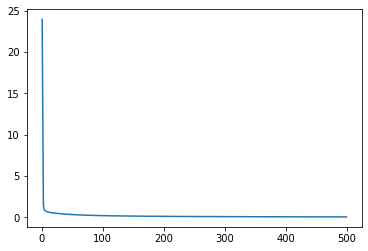

99.0


In [57]:
# Making loss array to store loss value after each epoch to compare loss values according to epoch
tmp = lr
loss = []

print("Now training the model on the training dataset divided in batches")

for epoch in range(epochs):
    # For adaptive gradient descent
    if lr_type == 1:
        lr = tmp/math.sqrt(epoch+1)

    total_loss = 0

    # Go over every batch and train my neural network
    for batch, Y in training_batch:
        values = []
        values.append(batch)

        # store original batch as this will get modified in next for loop
        batch1 = batch
        # Forward Propogation this batch so that it can be used in Backpropogation
        for i in range(len(layers)-1):
            batch = np.dot(batch, weights[i])
            if act_type == 0:
                batch = sigmoid(batch)
            elif act_type == 1:
                batch = tanh(batch)
            else:
                batch = relu(batch)
            
            # Concatenate with a columns of ones after output from each layer to absorb bias in the data
            batch = np.concatenate((np.ones((batch_size, 1)),batch), axis = 1)

            # catching this in values so that it can be used in backpropogation
            values.append(batch)
        
        # forward propogation for last layer
        batch = np.dot(batch, weights[i+1])

        # Activation function for last layer
        if loss_type == 0:
            output = softmax(batch)
        else:
            output = tanh(batch_size)

        # Final output of this neural network for this batch without tweeking weights wrong output most probably
        values.append(output)

        # Calculating derivative of loss function for backpropogation of neural net
        if loss_type == 0:
            der = (output-Y)/Y.shape[0]

        else:
            if act_type == 0:
                der = (output-Y)*derivative_sigmoid(output)/Y.shape[0]
            elif act_type:
                der = (output-Y)*derivative_tanh(output)/Y.shape[0]
            else:
                der = (output-Y)*derivative_relu(output)/Y.shape[0]
        
        # Back propogating error 
        for i in range(len(layers)-1,-1,-1):
            weight_copy = weights[i].copy()
            w = np.dot(values[i].T, der)

            weights[i] -= lr*w

            if act_type == 0:
                der = np.dot(der, weight_copy.T)*derivative_sigmoid(values[i])
            elif act_type == 1:
                der = np.dot(der, weight_copy.T)*derivative_tanh(values[i])
            else:
                der = np.dot(der, weight_copy.T)*derivative_relu(values[i])
            
            der = np.delete(der, 0, axis = 1)

        # Calculating predicted output of this batch to calculate loss value of this batch
        output = batch1
        for i in range(len(layers)-1):
            output = np.dot(output, weights[i])
            if act_type == 0:
                output = sigmoid(output)
            elif act_type == 1:
                output = tanh(output)
            else:
                output = relu(output)

            output = np.concatenate((np.ones((output.shape[0], 1)), output), axis = 1)
        
        # Forward propogating for output layer
        output = np.dot(output, weights[i+1])
        # Activation function for last layer
        if loss_type == 0:
            output = softmax(output)
        else:
            output = tanh(output)

        # According to loss type calculate loss value of this batch
        if loss_type == 0:
            total_loss += CE(Y, output)
        else:
            total_loss += MSE(Y, output)
    # append to this epoch's loss value
    loss.append(total_loss)

print("Graphical representation of Training Loss vs number of epochs -->")
plt.plot([(epoch+1) for epoch in range(epochs)], loss)
plt.show() 
        
# Predicting output for testing dataset
for i in range(len(layers)-1):
    X_test = np.concatenate((np.ones((X_test.shape[0],1)), X_test), axis = 1)
    X_test = np.dot(X_test, weights[i])
    
    if act_type == 0:
        X_test = sigmoid(X_test)
    elif act_type == 1:
        X_test = tanh(X_test)
    else:
        X_test = relu(X_test)

X_test = np.concatenate((np.ones((X_test.shape[0],1)), X_test), axis = 1)
X_test = np.dot(X_test, weights[i+1])

if loss_type == 0:
    output = softmax(X_test)
else:
    output = tanh(X_test)
pred = np.argmax(output, axis=1)

correct = 0
total = pred.shape[0]

for i in range(total):
    if pred[i] == Y_test[i]:
        correct+=1

print("Accuracy on testing dataset -->")
print((correct/total)*100)        